# Qiskit config

In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.test.mock import FakeMontreal, FakeMumbai

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'

backend_0  = Aer.get_backend('qasm_simulator') 
backend_1  = provider.get_backend('ibmq_qasm_simulator')
backend_2  = provider.get_backend('ibmq_santiago')
backend_3  = provider.get_backend('ibmq_manila')
backend_4  = provider.get_backend('ibmq_casablanca')
backend_5  = provider.get_backend('ibmq_jakarta')
backend_6  = FakeMontreal()
backend_7  = FakeMumbai()

shots      = 8192

In [2]:
"""
    Select the backends that will be compared.
"""
#backends = [ backend_0 ]
#backends = [ backend_0, backend_1 ]
#backends = [ backend_2, backend_3 ]
#backends = [ backend_4, backend_5 ]
backends = [ backend_6, backend_7 ]
#backends = [ backend_2, backend_3, backend_4, backend_5 ]

# Experiment procedures

In [9]:
import sys
sys.path.append('../../')
from qclib.state_preparation.bdsp import initialize

def measurement(circuit, c):
    n = len(c)
    circuit.measure(list(range(n)), c)

    job = execute(circuit, backend, shots=shots, optimization_level=3)
    
    counts = job.result().get_counts(circuit)
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**n):
        pattern = '{:0{}b}'.format(m, n)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0
            
    return { key : value/v for (key, value) in counts2.items() }
    
def bidirectional_experiment(state, s=None):
    circuit = initialize(state, s)

    n = int(np.log2(len(input_state)))
    c = ClassicalRegister(n)
    circuit.barrier()
    circuit.add_register(c)

    return measurement(circuit, c)


# Experiment

In [10]:
import numpy as np

"""
    Random complex input vector.
"""
#n = 3
#N = 2**n
#rng = np.random.default_rng(42)
#input_state = ((1.0 - 0.01) * rng.random(N) + 0.01) + ((1.0 - 0.01) * rng.random(N) + 0.01) * 1j
#input_state = input_state/np.linalg.norm(input_state)
""""""
"""
    Fixed real 8- and 16-dim input vector.
"""
input_state = [np.sqrt(0.03), np.sqrt(0.06), np.sqrt(0.15), np.sqrt(0.05), np.sqrt(0.1), np.sqrt(0.3), np.sqrt(0.2), np.sqrt(0.11) ]
#input_state = [np.sqrt(0.01), np.sqrt(0.02), np.sqrt(0.04), np.sqrt(0.02), np.sqrt(0.07), np.sqrt(0.08), np.sqrt(0.04), np.sqrt(0.01), np.sqrt(0.08), np.sqrt(0.02), np.sqrt(0.21), np.sqrt(0.09), np.sqrt(0.12), np.sqrt(0.08), np.sqrt(0.05), np.sqrt(0.06) ]
N = len(input_state)
n = int(np.log2(N))
""""""

print('n =', n)

ideal = np.power(np.abs(input_state),2)
print('\nInput vector probabilities (|x|^2):')
print({'{:0{}b}'.format(p, n) : a for p, a in enumerate(ideal)})

maes  = {}
probs = {}
for s in range(1, n+1):
    print('\ns =', s)
    backend_probs = {}
    backend_maes = {}
    for j, backend in enumerate(backends):
        backend_name = backend.name()
        backend_config = backend.configuration()
        backend_qubits = backend_config.n_qubits

        backend_probs[backend_name] = []

        print('\n\tExperiments using {0} backend, with {1} qubits available.'.format(backend_name, backend_qubits))

        for k in range(10):
            print('\tIter:', k)
            prob = bidirectional_experiment(input_state, s)
            backend_probs[backend_name].append([val for key, val in prob.items()])
            print('\t', dict(sorted(prob.items())) )

        backend_maes[backend_name] = np.sum(np.abs(np.mean(backend_probs[backend_name],axis=0)-ideal))/len(ideal)
        
    probs[s] = backend_probs
    maes[s]  = backend_maes


n = 3

Input vector probabilities (|x|^2):
{'000': 0.03, '001': 0.06, '010': 0.15000000000000002, '011': 0.049999999999999996, '100': 0.1, '101': 0.29999999999999993, '110': 0.19999999999999998, '111': 0.10999999999999999}

s = 1

	Experiments using fake_montreal backend, with 27 qubits available.
	Iter: 0
	 {'000': 0.0799560546875, '001': 0.079833984375, '010': 0.1197509765625, '011': 0.0777587890625, '100': 0.15478515625, '101': 0.2066650390625, '110': 0.14990234375, '111': 0.13134765625}
	Iter: 1
	 {'000': 0.0831298828125, '001': 0.0767822265625, '010': 0.1168212890625, '011': 0.0765380859375, '100': 0.1529541015625, '101': 0.1978759765625, '110': 0.1617431640625, '111': 0.1341552734375}
	Iter: 2
	 {'000': 0.0811767578125, '001': 0.0821533203125, '010': 0.110595703125, '011': 0.0718994140625, '100': 0.1585693359375, '101': 0.2164306640625, '110': 0.1551513671875, '111': 0.1240234375}
	Iter: 3
	 {'000': 0.088134765625, '001': 0.0762939453125, '010': 0.11767578125, '011': 0.0767822265

	 {'000': 0.0555419921875, '001': 0.078125, '010': 0.1439208984375, '011': 0.055908203125, '100': 0.10888671875, '101': 0.26220703125, '110': 0.1826171875, '111': 0.11279296875}
	Iter: 1
	 {'000': 0.0435791015625, '001': 0.0736083984375, '010': 0.144287109375, '011': 0.052978515625, '100': 0.114501953125, '101': 0.274169921875, '110': 0.1864013671875, '111': 0.1104736328125}
	Iter: 2
	 {'000': 0.045166015625, '001': 0.0792236328125, '010': 0.146240234375, '011': 0.05615234375, '100': 0.1080322265625, '101': 0.263671875, '110': 0.189453125, '111': 0.112060546875}
	Iter: 3
	 {'000': 0.0450439453125, '001': 0.0711669921875, '010': 0.1436767578125, '011': 0.05419921875, '100': 0.108642578125, '101': 0.27880859375, '110': 0.19189453125, '111': 0.1065673828125}
	Iter: 4
	 {'000': 0.0462646484375, '001': 0.0841064453125, '010': 0.1514892578125, '011': 0.055908203125, '100': 0.1002197265625, '101': 0.2691650390625, '110': 0.183349609375, '111': 0.1094970703125}
	Iter: 5
	 {'000': 0.04077148437

# Mean Absolute Error

In [11]:
for s, s_mae in maes.items():
    print('s = {0}'.format(s))
    for backend, mae in dict(sorted(s_mae.items(), key=lambda item: item[1])).items():
        print('\t{0} : MAE = {1}'.format(backend, mae))

s = 1
	fake_montreal : MAE = 0.04395446777343749
	fake_mumbai : MAE = 0.0486846923828125
s = 2
	fake_montreal : MAE = 0.026739501953124998
	fake_mumbai : MAE = 0.039910888671875
s = 3
	fake_montreal : MAE = 0.011114501953124996
	fake_mumbai : MAE = 0.024185180664062497


# Chart Data

In [12]:
for s, s_probs in probs.items():
    print('s = {0}'.format(s))
    for backend, backend_probs in s_probs.items():
        print('\t{0}'.format(backend))
        print('\t{0}'.format(str(np.mean(backend_probs, axis=0)).replace(' ', '\t')))

s = 1
	fake_montreal
	[0.08218994	0.08010254	0.11359863	0.07648926	0.15465088	0.20549316
	0.15509033	0.13238525]
	fake_mumbai
	[0.07937012	0.07935791	0.11169434	0.08822021	0.1640625		0.18762207
	0.15594482	0.13372803]
s = 2
	fake_montreal
	[0.06756592	0.08161621	0.14246826	0.06879883	0.12402344	0.23200684
	0.16856689	0.11495361]
	fake_mumbai
	[0.08748779	0.08448486	0.13027344	0.0769165		0.13448486	0.20407715
	0.15600586	0.12626953]
s = 3
	fake_montreal
	[0.04702148	0.07434082	0.14597168	0.05401611	0.10860596	0.27253418
	0.18703613	0.11047363]
	fake_mumbai
	[0.06831055	0.08980713	0.14331055	0.06899414	0.10761719	0.23793945
	0.17200928	0.11201172]


# Plot Charts

s = 1


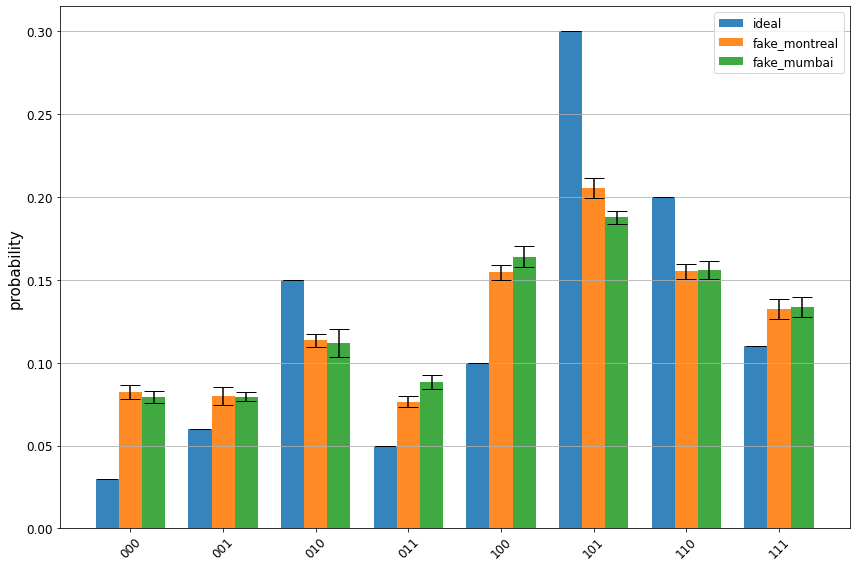

s = 2


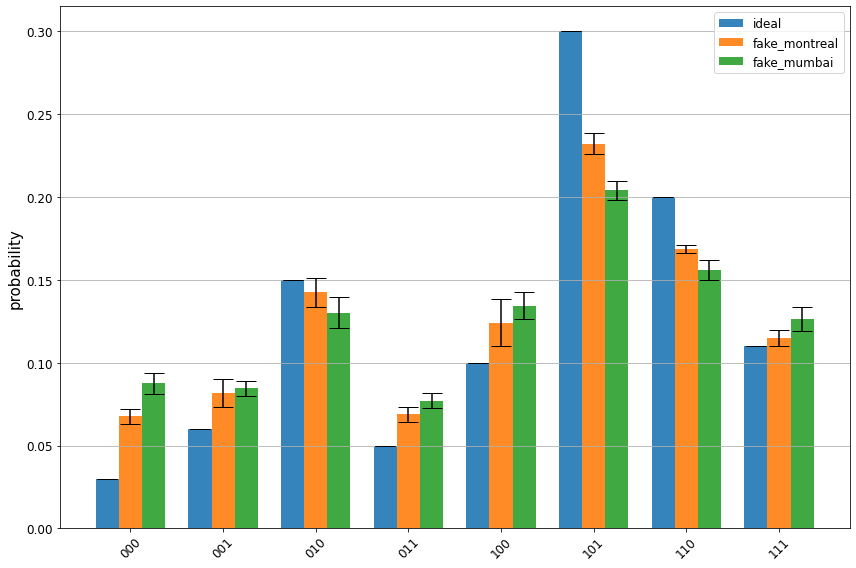

s = 3


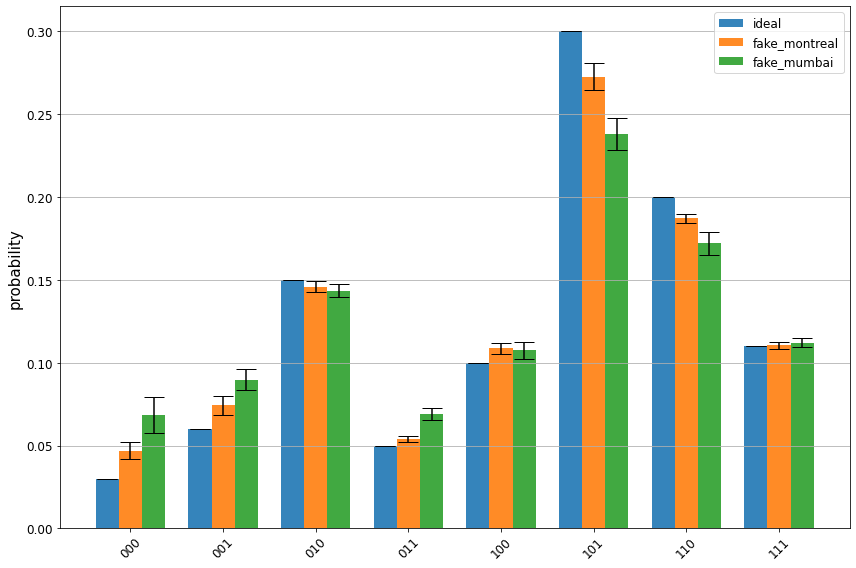

In [13]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot(labels, averages, stds, xticks):
    n_bars = len(xticks)
    n_labels = len(labels)
    
    b_width = (1/n_labels)*0.75
    fig = plt.subplots(figsize = (12, 8))

    x_pos = np.arange(n_bars)
    for i, avg in enumerate(averages):
        plt.bar(x_pos, avg, yerr = stds[i], width = b_width, label = labels[i],
                align='center', alpha=0.9, ecolor='black', capsize=b_width*40)
        
        x_pos = [x + b_width for x in x_pos]
    
    plt.ylabel('probability', fontsize = 15)
    plt.xticks([x + b_width*(n_labels-1)/2 for x in range(n_bars)], xticks, fontsize=12, rotation=45)
    plt.grid(b=True, axis='y')
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

def plot_result(ideal, probs):
    labels   = [ key for key, val in probs.items() ]
    averages = [ np.mean(prob, axis=0) for key, prob in probs.items() ]
    stds     = [ np.std(prob , axis=0) for key, prob in probs.items() ]
    xticks   = ['{:0{}b}'.format(p, n) for p, a in enumerate(input_state)]

    labels.insert(0, 'ideal')
    averages.insert(0, ideal)
    stds.insert(0, [0]*len(ideal))

    plot(labels, averages, stds, xticks)

for s in range(1, n+1):
    print('s =', s)
    plot_result(ideal, probs[s])